In [1]:
# 导入必要的库
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split

# 加载数据
rawdata = pd.read_csv('./dataset/rawdata.csv')
rawdata['date']=pd.to_numeric(pd.to_datetime(rawdata['date']))
data = rawdata.values.astype('float32')
rawdata.head(10)

,date,single,accumulate,y1,y2,y3
0,1663286400000000000,0.0,391.9,4.1,-7.2,8.3
1,1663200000000000000,0.0,391.9,3.8,-7.8,8.7
2,1663113600000000000,0.0,391.9,3.9,-9.4,10.2
3,1663027200000000000,0.0,391.9,3.9,-9.3,10.1
4,1662940800000000000,0.0,391.9,4.0,-8.3,9.2
5,1662854400000000000,0.0,391.9,4.0,-7.5,8.5
6,1662768000000000000,0.0,391.9,4.2,-8.1,9.1
7,1662681600000000000,0.0,391.9,3.5,-7.4,8.2
8,1662595200000000000,0.0,391.9,4.1,-7.9,8.9
9,1662508800000000000,0.0,391.9,3.8,-9.2,10.0


In [2]:
input_window = 6
output_window = 1
data[input_window:input_window+output_window][:,-3:]

array([[ 4.2, -8.1,  9.1]], dtype=float32)

### 归一化和反归一化

In [3]:
from sklearn.preprocessing import MinMaxScaler

# 创建MinMaxScaler对象
scaler = MinMaxScaler()
# 归一化数据
data = scaler.fit_transform(data)
joblib.dump(scaler,'scaler.pkl')
# # 反归一化数据
# X_original = scaler.inverse_transform(X_normalized)


['scaler.pkl']

### 滑动窗口切分时间序列

In [4]:
# 滑动窗口大小
input_window = 6
output_window = 1
x=[]
y=[]
# 创建滑动窗口
dataset = []
for i in range(len(data) - (input_window+output_window)):
    x.append(data[i:i+input_window])
    y.append(data[i+input_window:i+input_window+output_window][:,-3:])

### 划分数据集

In [5]:
train_X, test_X, train_Y, test_Y = train_test_split(x, y, test_size=0.2, random_state=42)
# 转换为张量
train_X = torch.from_numpy(np.array(train_X)).float()
train_Y = torch.from_numpy(np.array(train_Y)).float()
test_X = torch.from_numpy(np.array(test_X)).float()
test_Y = torch.from_numpy(np.array(test_Y)).float()

In [6]:
loss_lst=[]

In [7]:

# 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# 定义超参数
input_size = 6
hidden_size = 32
num_layers = 1
output_size = 3
learning_rate = 0.001
num_epochs = 100
loss_item = []
# 初始化模型
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型
for epoch in range(num_epochs):
    # 前向传播
    outputs = model(train_X)
    loss = criterion(outputs, train_Y)
    # 反向传播并优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_item.append(loss.item())
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
loss_lst.append(loss_item)

/home/linjw/anaconda3/envs/biobase/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([350, 1, 3])) that is different to the input size (torch.Size([350, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/100], Loss: 0.3349
Epoch [2/100], Loss: 0.3259
Epoch [3/100], Loss: 0.3170
Epoch [4/100], Loss: 0.3083
Epoch [5/100], Loss: 0.2997
Epoch [6/100], Loss: 0.2911
Epoch [7/100], Loss: 0.2827
Epoch [8/100], Loss: 0.2743
Epoch [9/100], Loss: 0.2660
Epoch [10/100], Loss: 0.2577
Epoch [11/100], Loss: 0.2495
Epoch [12/100], Loss: 0.2412
Epoch [13/100], Loss: 0.2330
Epoch [14/100], Loss: 0.2247
Epoch [15/100], Loss: 0.2163
Epoch [16/100], Loss: 0.2080
Epoch [17/100], Loss: 0.1995
Epoch [18/100], Loss: 0.1910
Epoch [19/100], Loss: 0.1824
Epoch [20/100], Loss: 0.1738
Epoch [21/100], Loss: 0.1651
Epoch [22/100], Loss: 0.1563
Epoch [23/100], Loss: 0.1475
Epoch [24/100], Loss: 0.1387
Epoch [25/100], Loss: 0.1299
Epoch [26/100], Loss: 0.1212
Epoch [27/100], Loss: 0.1126
Epoch [28/100], Loss: 0.1043
Epoch [29/100], Loss: 0.0963
Epoch [30/100], Loss: 0.0886
Epoch [31/100], Loss: 0.0816
Epoch [32/100], Loss: 0.0751
Epoch [33/100], Loss: 0.0695
Epoch [34/100], Loss: 0.0646
Epoch [35/100], Loss: 0

In [8]:
# import matplotlib.pyplot as plt

# # 创建x轴的数据，假设loss_list长度为1000
# x = range(len(loss_item))

# # 画图
# plt.plot(x, loss_lst[0], lw=2,label='Learn Rate = 0.0001')
# plt.plot(x, loss_lst[1],lw=2, label='Learn Rate = 0.001')
# plt.plot(x, loss_lst[2],lw=2, label='Learn Rate = 0.01')

# # 设置图像的标题和轴标签
# plt.title('LSTM Loss Curve')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# # 显示图例
# plt.legend()
# # 显示图像
# plt.show()


### 模型测试

In [9]:
# 测试模型
model.eval()
outputs = model(test_X)

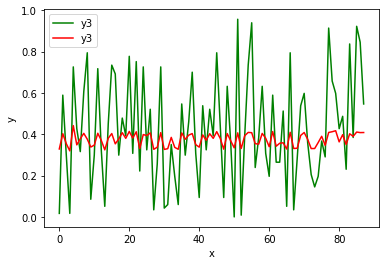

In [10]:
import matplotlib.pyplot as plt


# 定义 Groundtruth 和 Predict 数据
gt = np.squeeze(test_Y, axis=1)
pred = outputs.detach().cpu().numpy()

plt.plot([x[2] for x in gt], c='g',label='y3')
plt.plot([x[2] for x in pred],c='r',label='y3')

# 添加图例和标签
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [18]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
true=np.array([x[2]*4 for x in gt])
ypre=np.array([x[2]*4 for x in pred])
# 平均绝对误差（MAE）
mae = mean_absolute_error(true, ypre)

# 均方误差（MSE）
mse = mean_squared_error(true, ypre)

# 均方根误差（RMSE）
rmse = np.sqrt(mse)

# 平均绝对百分比误差（MAPE）
mape = np.mean(np.abs((true - ypre) / np.maximum(np.abs(true), 1e-8))) * 100

# 平均平方百分比误差（MSPE）
mspe = np.mean(np.square((true - ypre) / np.maximum(np.abs(true), 1e-8))) * 100


In [19]:
# 创建DataFrame
df = pd.DataFrame({
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'MAPE': [mape],
    'MSPE': [mspe]
})
df

,MAE,MSE,RMSE,MAPE,MSPE
0,0.760749,0.887397,0.942018,1.520883e+08,2.035510e+16
